In [1]:
import pandas as pd
from pandas import read_csv

male_edges = {(int(str.removeprefix(r[1], "m")), int(str.removeprefix(r[2], "m"))): int(r[3]) 
                for r in read_csv("male_connectome_graph.csv").itertuples()}
female_edges = {(int(str.removeprefix(r[1], "f")), int(str.removeprefix(r[2], "f"))): int(r[3])
                for r in read_csv("female_connectome_graph.csv").itertuples()}
matching = {int(str.removeprefix(r[1], "m")): int(str.removeprefix(r[2], "f")) for r in read_csv("benchmark.csv").itertuples()}
alignment = 0

#for male_nodes, edge_weight in male_edges.items():
#  female_nodes = (matching[male_nodes[0]], matching[male_nodes[1]])
#  alignment += min(edge_weight, female_edges.get(female_nodes, 0))

#print(f"{alignment=}")

In [46]:
import numpy as np
import scipy as sp

def get_csr_matrix(edges):

    data = []
    coords = ([],[])

    for (u,v), weight in edges.items():
        coords[0].append(u-1)
        coords[1].append(v-1)
        data.append(weight)

    M=sp.sparse.coo_array((data,coords)).astype(dtype=float).tocsr()

    return M

def score(M, F, mapping):

    check = np.zeros(len(mapping),dtype=bool)
    check[mapping] = True
    if check.min() == False:
        raise Exception("Mapping to be scored is not injective!")

    if isinstance(M,sp.sparse.csr_array):
        S=sp.sparse.csr_array.minimum(M,F[mapping[:,None],mapping])
        return S.sum()
    else:
        return np.minimum(M,F[mapping[:,None],mapping]).sum()

M = get_csr_matrix(male_edges)
F = get_csr_matrix(female_edges)
n = M.shape[0]

benchmark_mapping = np.zeros(n,dtype=int)
for u,v in matching.items():
    benchmark_mapping[u-1] = v-1

In [3]:
A = M.todense()
B = F.todense()

Analyzing the distribution of degrees

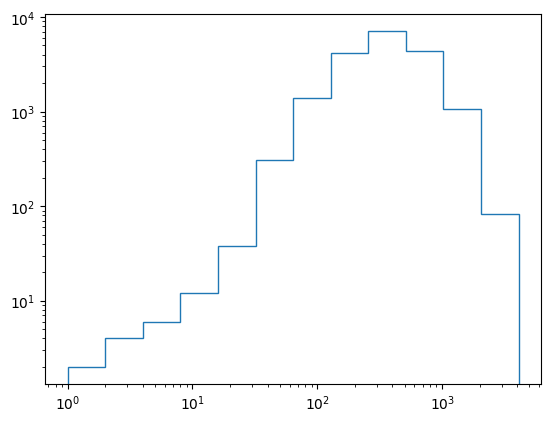

In [96]:
import matplotlib.pyplot as plt

total_degrees = (M!=0).astype(dtype=int).sum(axis=1)+(M!=0).astype(dtype=int).sum(axis=0)
values, edges=np.histogram(total_degrees, [2**k for k in range(int(np.log2(total_degrees.max()))+1)])
patch = plt.stairs(values, edges)
patch.axes.set_xscale("log")
patch.axes.set_yscale("log")
#np.concatenate([np.arange(bincounts.shape[0]).reshape(-1,1),bincounts.reshape(-1,1)],axis=1)

In [ ]:
map_from = []
map_to = []
mapping = -np.ones(n,dtype=int)
c = 0.0001

priority = c*A.sum(axis=1)
base_F = c*B.sum(axis=1)

for i in range(n):

    u = priority.argmax()

    in_neighbors = np.flatnonzero(A[:,u])
    mapped_in_neighbors = in_neighbors[mapping[in_neighbors] != -1]

    connection_F = base_F.copy()

    connection_F += np.minimum(A[mapped_in_neighbors,u,None],B[mapping[mapped_in_neighbors],:]).sum(axis=0)

    connection_F[map_to] = -1
    v = connection_F.argmax()
    map_from.append(u)
    map_to.append(v)
    mapping[u] = v

    priority += A[u,:]
    priority[map_from] = -1

    print(f"{i=}",end="\r")

#mapping[map_from] = map_to
mapping


KeyboardInterrupt: 

In [29]:
from algorithms import invert
score(M,F,np.arange(n)), score(M,F,mapping), score(M,F,invert(mapping)), score(M,F,benchmark_mapping)

(45445.0, 45041.0, 1349587.0, 5154247.0)

In [ ]:

triangles = 0
for u in range(n):
    neighbors = np.flatnonzero(C[u,:])
    local_triangles = 0
    for v in neighbors:
        local_triangles += C[[v],neighbors].sum()

    triangles += local_triangles
    if local_triangles > len(neighbors)**2:
        raise Exception("Too many triangles")

    print(f"{u=}",end="\r")
triangles

In [ ]:
neighbors = np.flatnonzero(M[[8976],:].todense())
subgraph = M[neighbors[:,None],neighbors[None,:]]
m=len(neighbors)
e=subgraph.count_nonzero()
m,e,e/m**2

(83, 2166, 0.31441428364058643)

In [3]:
def get_best_connected(X, m:int):
    total_degrees = (X!=0).sum(axis=1)+(X!=0).sum(axis = 0)
    index_order = np.argsort(total_degrees)
    U = index_order[-m:]
    return X[U[:,None],U[None,:]], index_order[-m:]

In [4]:
m=50
H_M,M_positions = get_best_connected(M,m)
H_F,F_positions = get_best_connected(F,m)
H_M = H_M.todense()
H_F = H_F.todense()
np.count_nonzero(H_M)/m**2, np.count_nonzero(H_F)/m**2

(0.5872, 0.3272)

In [66]:
from algorithms import random_swaps
H_mapping = np.arange(m)

print(f"Starting score={score(H_F,H_M,H_mapping)}")
random_swaps(H_F, H_M,H_mapping,steps=100000)
print(f"Final score={score(H_F,H_M,H_mapping)}")

Starting score=1099.0
Final score=2409.0


In [69]:
from algorithms import greedy_mapping
start_mapping=-np.ones(n,dtype=int)
start_mapping[F_positions] = M_positions[H_mapping]
mapping = greedy_mapping(B,A,start_mapping)

In [15]:
np.save("Mapping-06-12-24 (2.5Mio).arr",mapping)

In [ ]:
swaps = 100000
G=H_F
H=H_M
print(f"Self score={score(H,H,np.arange(m))}")
print(f"Starting score={score(G,H,H_mapping)}")

s = score(G,H,H_mapping)
test = np.zeros(m,dtype=int)

for i in range(swaps):
    np.copyto(test,H_mapping)

    k=2+rng.poisson(0.5)

    v = rng.choice(m,k,replace=False)
    for j in range(k):
        test[v[j]] = H_mapping[v[(j+1)%k]]

    t = score(G,H,test)
    if t>s:
        s=t
        tmp = H_mapping
        H_mapping = test
        test = tmp

    print(f"{i=}, {s=}",end="\r")

print(f"\n Final score={score(G,H,H_mapping)}")

Self score=8664.0
Starting score=2468.0
i=99999, s=2493.0
 Final score=2493.0


In [ ]:
from algorithms import swap_score

rng = np.random.default_rng()
H_mapping = rng.permutation(m)
print(f"Starting score={score(H_F,H_M,H_mapping)}")

swaps = 100

for i in range(swaps):
    change_made = False
    for u in range(m):
        for v in range(m):
            if u == v:
                continue

            if swap_score(H_F,H_M,H_mapping,u,v)>0:
                tmp = H_mapping[u]
                H_mapping[u] = H_mapping[v]
                H_mapping[v] = tmp
                change_made = True
                break

    print(f"{i=}, {score(H_F,H_M,H_mapping)=}",end="\r")
    if not change_made:
        print(f"\n No change made on iteration {i}.")
        break

print(f"\n Final score={score(H_F,H_M,H_mapping)}")
    

Starting score=5805.0
i=10, score(H_F,H_M,H_mapping)=19371.0
 No change made on iteration 10.

 Final score=19371.0


In [ ]:
rng = np.random.default_rng()

In [72]:
from algorithms import random_swaps

def random_graph(n):

    G = rng.integers(2,size=(n,n))
    G[np.arange(n),np.arange(n)] = 0
    return G

def find_preferences(G,H,iterations = 100, swaps = 10000,verbose=True):

    m = G.shape[0]
    result_matrix = np.zeros((m,m),dtype=int)

    for k in range(iterations):

        mapping = rng.permutation(m)
        random_swaps(G,H,mapping,swaps,verbose=False)
        np.add.at(result_matrix,(np.arange(m),mapping),1)
        if verbose:
            print(f"{k=}"+" " * 20,end="\r")

    return result_matrix

def generate_hint(G,H,iterations,swaps):

    m = G.shape[0]
    result_matrix = find_preferences(G,H,iterations,swaps)
    best=result_matrix.argmax(axis=1)
    best_scores = result_matrix[np.arange(m),best]

    score_list = best_scores.argsort()[::-1]
    mapping = -np.ones(m,dtype=int)
    inverse = -np.ones(m,dtype=int)

    for u in score_list:
        if inverse[best[u]] == -1:
            mapping[u] = best[u]
            inverse[best[u]] = u
        else:
            break

    unmapped_sources = np.flatnonzero(mapping==-1)
    unmapped_targets = np.flatnonzero(inverse==-1)
    mapping[unmapped_sources] = rng.permutation(unmapped_targets)

    return mapping

def shuffle_graph(G):

    n = G.shape[0]
    shuffle = rng.permutation(n)
    H = G[shuffle[:,None],shuffle[None,:]]
    return H, shuffle

In [ ]:
m=50
G=random_graph(m)
H,shuffle=shuffle_graph(G)
#candidates = np.concatenate([shuffle[best,None],np.arange(m)[:,None]],axis=1)[best_scores >50]
mapping=generate_hint(G,H,100,10000)
random_swaps(G,H,mapping,10000)
score(G,H,mapping),score(G,G,np.arange(m))

(1274, 1274)